ELECTRONS ARE COMING. Use PLAY or drag the FRAME slider!


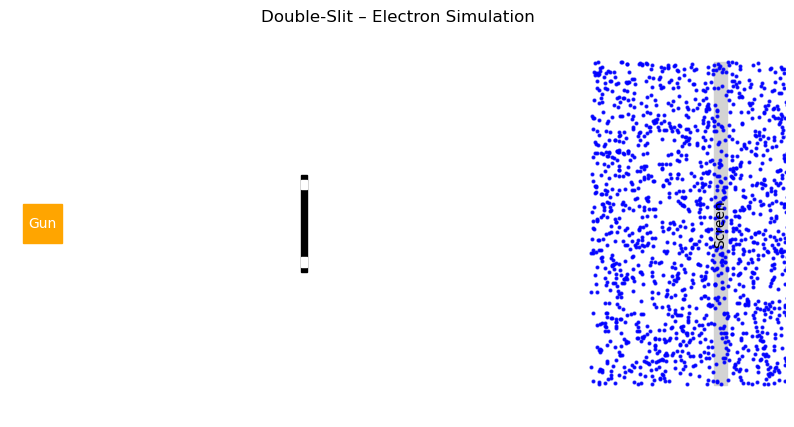

In [1]:
# --------------------------------------------------------------
# 0. FORCE CLASSIC NOTEBOOK
# --------------------------------------------------------------
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import matplotlib
matplotlib.rcParams['animation.html'] = 'jshtml'

# --------------------------------------------------------------
# 1. SIMULATOR – FIXED & ROBUST
# --------------------------------------------------------------
class DoubleSlitSimulator:
    def __init__(self):
        self.reset_simulation()
        self.fig, self.ax = plt.subplots(figsize=(10,6))
        self.setup_plot()
        self.animation = None

    def reset_simulation(self):
        self.slit_separation = 1.2
        self.slit_width = 0.15
        self.screen_distance = 5.0
        self.electron_flux = 50
        self.momentum = 15.0
        self.quantum_on = True
        self.pilot_wave_mode = False
        self.wavelength = 2 * np.pi / self.momentum
        self.screen_hits = []
        self.path_lines = []
        self.time = 0.0
        self.frame = 0

    def setup_plot(self):
        self.ax.clear()
        self.ax.set_xlim(-6, 6)
        self.ax.set_ylim(-3, 3)
        self.ax.set_aspect('equal')
        self.ax.set_title("Double-Slit – Electron Simulation")
        self.ax.axis('off')

        # Gun
        self.ax.add_patch(Rectangle((-5.8, -0.3), 0.6, 0.6, color='orange'))
        self.ax.text(-5.5, 0, 'Gun', ha='center', va='center', color='white', fontsize=10)

        # Screen
        self.screen_rect = Rectangle((self.screen_distance - 0.1, -2.5), 0.2, 5, color='lightgray')
        self.ax.add_patch(self.screen_rect)
        self.ax.text(self.screen_distance, 0, 'Screen', rotation=90, ha='center', va='center', fontsize=10)

        # Hits plot
        self.hits_plot, = self.ax.plot([], [], 'b.', ms=2, alpha=0.7)

        # Barrier (will be updated)
        self.barrier_patches = []
        self._update_barrier()

    def _update_barrier(self):
        for p in self.barrier_patches:
            p.remove()
        self.barrier_patches = []

        half = self.slit_separation / 2 + self.slit_width
        self.barrier_patches.append(
            self.ax.add_patch(Rectangle((-1.5, -half), 0.1, 2 * half, color='black'))
        )
        for y in (self.slit_separation / 2, -self.slit_separation / 2):
            self.barrier_patches.append(
                self.ax.add_patch(Rectangle((-1.5, y - self.slit_width / 2), 0.1, self.slit_width, color='white'))
            )

    def _single_slit(self, y_slit, x_screen):
        a, k = self.slit_width, 2 * np.pi / self.wavelength
        r = np.hypot(x_screen + 1.5, y_slit)
        sin_theta = (x_screen + 1.5) / r
        beta = k * a * sin_theta / 2
        return (np.sinc(beta / np.pi))**2

    def _interference_probability(self, x):
        d = self.slit_separation
        I1 = self._single_slit(d / 2, x)
        I2 = self._single_slit(-d / 2, x)
        if not self.quantum_on:
            return I1 + I2
        r1 = np.hypot(x + 1.5, d / 2)
        r2 = np.hypot(x + 1.5, -d / 2)
        delta = (2 * np.pi / self.wavelength) * (r2 - r1)
        return 4 * I1 * (1 + np.cos(delta))

    def _sample_hit(self):
        x = np.linspace(self.screen_distance - 2, self.screen_distance + 2, 1200)
        p = self._interference_probability(x)
        p = np.nan_to_num(p)
        p /= p.sum() or 1
        return x[np.random.choice(len(x), p=p)]

    def _pilot_path(self, y0):
        path = [(-5.0, y0)]
        x, y = -5.0, y0
        dt, dx = 0.04, 0.08
        while x < self.screen_distance:
            x += dx
            if x < -1.4:
                y += np.random.normal(0, 0.015)
            else:
                inside_u = abs(y - self.slit_separation / 2) < self.slit_width / 2
                inside_l = abs(y + self.slit_separation / 2) < self.slit_width / 2
                if not (inside_u or inside_l):
                    break
                y += np.random.normal(0, 0.008)
            path.append((x, y))
        return path

    def step(self):
        self.time += 0.05
        n = max(1, int(self.electron_flux * 0.05))
        new_hits = []
        new_lines = []

        for _ in range(n):
            if self.pilot_wave_mode:
                y0 = np.random.uniform(-0.3, 0.3)
                traj = self._pilot_path(y0)
                if len(traj) > 1:
                    xs, ys = zip(*traj)
                    line, = self.ax.plot(xs, ys, 'c-', lw=0.8, alpha=0.6)
                    new_lines.append(line)
                    fx, fy = traj[-1]
                    new_hits.append((fx, fy))
                    self.ax.plot(fx, fy, 'ro', ms=3, alpha=0.9)
            else:
                xhit = self._sample_hit()
                yhit = np.random.uniform(-2.5, 2.5)
                new_hits.append((xhit, yhit))
                self.ax.plot(xhit, yhit, 'bo', ms=2, alpha=0.7)

        self.screen_hits.extend(new_hits)
        self.path_lines.extend(new_lines)

        if self.screen_hits:
            xs, ys = zip(*self.screen_hits)
            self.hits_plot.set_data(xs, ys)

        self._update_barrier()
        self.frame += 1

    def reset(self):
        for line in self.path_lines:
            try: line.remove()
            except: pass
        self.path_lines = []
        self.screen_hits = []
        self.time = 0.0
        self.frame = 0
        self.setup_plot()

# --------------------------------------------------------------
# 2. CREATE SIM & UI
# --------------------------------------------------------------
sim = DoubleSlitSimulator()

# UI Sliders
slit_sep = widgets.FloatSlider(description='Slit sep', min=0.1, max=1.5, step=0.05, value=1.2)
slit_width = widgets.FloatSlider(description='Slit width', min=0.05, max=0.3, step=0.01, value=0.15)
screen_dist = widgets.FloatSlider(description='Screen dist', min=2.0, max=10., step=0.5, value=5.0)
flux = widgets.IntSlider(description='Flux e⁻/s', min=1, max=200, step=10, value=50)
momentum = widgets.FloatSlider(description='Momentum', min=2.0, max=30., step=1.0, value=15.0)
quantum_on = widgets.Checkbox(description='Quantum', value=True)
pilot_wave = widgets.Checkbox(description='Pilot-wave', value=False)

ui = widgets.VBox([
    slit_sep, slit_width, screen_dist, flux, momentum, quantum_on, pilot_wave
], layout=widgets.Layout(width='300px', padding='10px', border='1px solid #ccc'))

# Output
output = widgets.Output()

# Animation control
play = widgets.Play(min=0, max=1000, step=1, interval=50, value=0)
frame_slider = widgets.IntSlider(min=0, max=1000, value=0, description='Frame', continuous_update=False)
reset_btn = widgets.Button(description="RESET", button_style='danger')

widgets.jslink((play, 'value'), (frame_slider, 'value'))
control_bar = widgets.HBox([play, frame_slider, reset_btn])

# --------------------------------------------------------------
# 3. ANIMATION SETUP (ONE-TIME)
# --------------------------------------------------------------
def create_animation():
    with output:
        clear_output(wait=True)
        sim.animation = FuncAnimation(
            sim.fig,
            lambda f: sim.step(),
            frames=1000,
            init_func=lambda: None,
            interval=50,
            repeat=False,
            cache_frame_data=False,
            blit=False
        )
        display(sim.animation)

# Initial display
create_animation()

# --------------------------------------------------------------
# 4. SYNC UI → SIM
# --------------------------------------------------------------
def sync_params(change):
    sim.slit_separation = slit_sep.value
    sim.slit_width = slit_width.value
    sim.screen_distance = screen_dist.value
    sim.electron_flux = flux.value
    sim.momentum = momentum.value
    sim.wavelength = 2 * np.pi / sim.momentum
    sim.quantum_on = quantum_on.value
    sim.pilot_wave_mode = pilot_wave.value

    # Reset if geometry or momentum changes
    if change['owner'] in {slit_sep, slit_width, screen_dist, momentum}:
        sim.reset()
        create_animation()
    else:
        sim._update_barrier()

for w in ui.children:
    w.observe(sync_params, 'value')

# --------------------------------------------------------------
# 5. FRAME SLIDER CONTROL
# --------------------------------------------------------------
def on_frame_change(change):
    target = change['new']
    current = sim.frame

    if target < current:
        sim.reset()
        current = 0

    # Step forward to target
    while current < target:
        sim.step()
        current += 1

    # Update animation display
    with output:
        clear_output(wait=True)
        display(sim.fig)

frame_slider.observe(on_frame_change, 'value')

# --------------------------------------------------------------
# 6. RESET BUTTON
# --------------------------------------------------------------
def on_reset(_):
    sim.reset()
    play.value = 0
    frame_slider.value = 0
    create_animation()

reset_btn.on_click(on_reset)

# --------------------------------------------------------------
# 7. FINAL DISPLAY
# --------------------------------------------------------------
app = widgets.VBox([
    widgets.HBox([ui, output]),
    control_bar
])
display(app)

print("ELECTRONS ARE COMING. Use PLAY or drag the FRAME slider!")